<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Evaluacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de módulos que se emplean en el notebook

In [1]:
!pip install -q aequitas

     |████████████████████████████████| 2.2 MB 4.9 MB/s 
     |████████████████████████████████| 83 kB 1.1 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
     |████████████████████████████████| 97 kB 5.8 MB/s 
     |████████████████████████████████| 727 kB 47.4 MB/s 
     |████████████████████████████████| 161 kB 46.2 MB/s 
     |████████████████████████████████| 456 kB 47.0 MB/s 
     |████████████████████████████████| 232 kB 24.8 MB/s 
     |████████████████████████████████| 2.8 MB 25.8 MB/s 
     |████████████████████████████████| 3.2 MB 33.5 MB/s 


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()

# Módulos para evaluar rendimiento
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# Módulos para evaluar equidad
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# Se monta el Google Drive
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/TFG/')
from TFG_Comun import TFG_METADATA, TFG_PREDICCIONES 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definición de funciones

In [3]:
# Función para mostrar la matriz de confusión
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    plt.ylabel('Diagnóstico real')
    plt.xlabel('Predicción del modelo')

    print('Verdadero negativo: ', cm[0][0])
    print('Falso positivo: ', cm[0][1])
    print('Falso negativo: ', cm[1][0])
    print('Vardadero positivo: ', cm[1][1])


## Preparación de los dataframes

In [4]:
# Fichero con las predicciones del modelo
file_predictions = TFG_PREDICCIONES
# Fichero de metadatos de los/las pacientes
file_metadata = TFG_METADATA

# Carga del fichero con las predicciones (probabilidades) del modelo
df_predictions = pd.read_csv(file_predictions)

# Carga del fichero con los metadatos de los/las pacientes
df_metadata = pd.read_csv(file_metadata)
# Se cambia el nombre de la columna del diagnóstico real 
# en el dataframe de predicciones
df_predictions.rename(columns = {'target':'target_p'}, inplace = True)

print("Número de registros en fichero de metadatos:", len(df_metadata))
print("Número de registros en fichero de predicciones del conjunto de datos de prueba:", len(df_predictions))

Número de registros en fichero de metadatos: 23257
Número de registros en fichero de predicciones del conjunto de datos de prueba: 3483


In [5]:
# Se combinan (inner join) ambos dataframes por la columna image_name
df_total = pd.merge(df_metadata, df_predictions, on='image_name')

In [6]:
# Se crea una columna con la predicción en binario
df_total['prediction_binary'] = np.where(df_total['prediction'] > 0.5, 1, 0)

In [7]:
# Se comprueba que las etiquetas del fichero de metadados 
# y del fichero de predicciones son la misma 
print(len(df_total[df_total['target']!=df_total['target_p']]))

0


In [8]:
# Se muestran los primeros registros del dataframe combinado
df_total.head(10)

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tipo_ITA,age_group_approx,target_p,prediction,prediction_binary
0,ISIC_0000001,female,30.0,anterior torso,NV,benign,0,6,"(15, 30]",0,0.000136,0
1,ISIC_0000003,male,30.0,upper extremity,NV,benign,0,1,"(15, 30]",0,0.050628,0
2,ISIC_0000009,female,30.0,anterior torso,NV,benign,0,1,"(15, 30]",0,0.000022,0
3,ISIC_0000016,female,55.0,anterior torso,NV,benign,0,6,"(45, 60]",0,0.141309,0
4,ISIC_0000072,male,85.0,posterior torso,NV,benign,0,1,"(75, 90]",0,0.360571,0
5,ISIC_0000157,male,60.0,upper extremity,MEL,malignant,1,1,"(45, 60]",1,0.947504,1
6,ISIC_0000167,male,40.0,posterior torso,MEL,malignant,1,1,"(30, 45]",1,0.986369,1
7,ISIC_0000172,female,35.0,posterior torso,MEL,malignant,1,1,"(30, 45]",1,0.940076,1
8,ISIC_0000198,male,65.0,lower extremity,NV,benign,0,2,"(60, 75]",0,0.003076,0
9,ISIC_0000199,male,20.0,upper extremity,NV,benign,0,1,"(15, 30]",0,0.003652,0


## Evaluación del rendimiento

In [9]:
# Diagnóstico real
y_true = list(df_total['target'])
# Diagnóstico predicho (probabilidad)
y_pred = list(df_total['prediction'])
# Diagnóstico predicho (binario)
y_pred_binary = list(df_total['prediction_binary'])

### Curva ROC

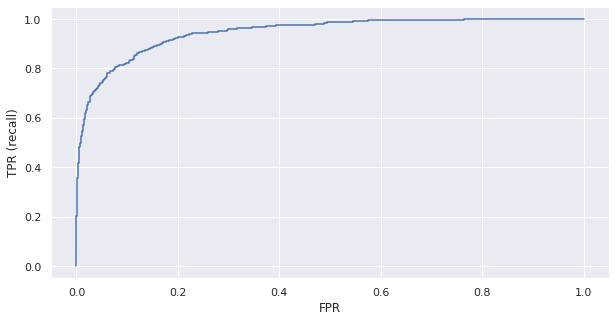

AUC: 0.946


In [45]:
# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.show()

auc = roc_auc_score(y_true, y_pred)
print("AUC: {0:.3f}".format(auc))

### Curva Precisión-Sensibilidad

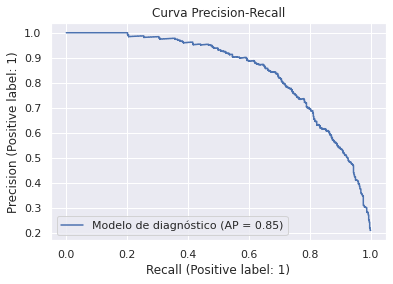

In [44]:
display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, 
                                                  name="Modelo de diagnóstico");
_ = display.ax_.set_title("Curva Precision-Recall");

### Matriz de confusión

Verdadero negativo:  2689
Falso positivo:  173
Falso negativo:  139
Vardadero positivo:  482


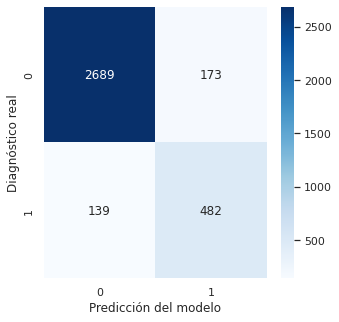

In [46]:
# Matriz de confusión
show_confusion_matrix(y_true, y_pred_binary)

In [13]:
# Métricas precisión, sensibilidad y F1
metrics = precision_recall_fscore_support(y_true, y_pred_binary)
print("Precisión:", round(metrics[0][1],2))
print("Sensibilidad:", round(metrics[1][1],2))
print("Puntuación F1:", round(metrics[2][1],2))

Precisión: 0.74
Sensibilidad: 0.78
Puntuación F1: 0.76


## Evaluación de la equidad

In [14]:
# Se crea el dataframe que se va a utilizar para la evaluación de la equidad
df_fairness = df_total.copy()
# Se necesitan tener las columnas label_value y score
df_fairness = df_fairness.rename(columns={"target": "label_value", "prediction_binary": "score"})
df_fairness["age_group_approx"] = df_fairness["age_group_approx"].astype(str)
df_fairness["tipo_ITA"] = df_fairness["tipo_ITA"].astype(str)
# Se eliminan columnas innecesarias,
df_fairness = df_fairness.drop(['image_name', 'benign_malignant', 'diagnosis', 
                          'age_approx', 'anatom_site_general_challenge',
                          'target_p',
                          'prediction'], axis=1)
df_fairness.head()

,sex,label_value,tipo_ITA,age_group_approx,score
0,female,0,6,"(15, 30]",0
1,male,0,1,"(15, 30]",0
2,female,0,1,"(15, 30]",0
3,female,0,6,"(45, 60]",0
4,male,0,1,"(75, 90]",0


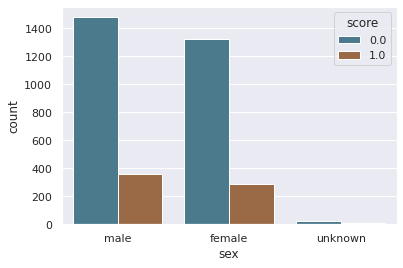

In [47]:
aq_palette = sns.diverging_palette(225, 35, n=2)
by_sex = sns.countplot(x="sex", hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

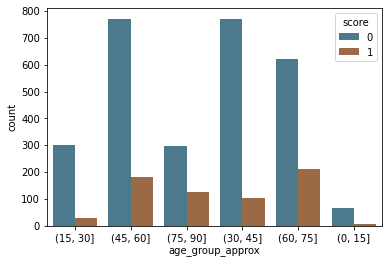

In [16]:
by_age = sns.countplot(x="age_group_approx", 
                       hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

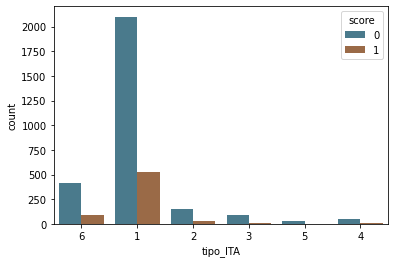

In [17]:
by_ITA = sns.countplot(x="tipo_ITA", 
                       hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

In [18]:
g = Group()
xtab, _ = g.get_crosstabs(df_fairness)

In [19]:
absolute_metrics = g.list_absolute_metrics(xtab)

## Cálculo de métricas de equidad:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |

In [20]:
data_equity = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
data_equity

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,female,0.74,0.94,0.06,0.27,0.06,0.26,0.94,0.73,0.44,0.18,0.18
1,sex,male,0.80,0.94,0.04,0.26,0.06,0.20,0.96,0.74,0.55,0.20,0.18
2,sex,unknown,1.00,0.89,0.00,0.50,0.11,0.00,1.00,0.50,0.01,0.19,0.10
3,tipo_ITA,1,0.80,0.94,0.05,0.26,0.06,0.20,0.95,0.74,0.80,0.20,0.19
4,tipo_ITA,2,0.81,0.95,0.03,0.25,0.05,0.19,0.97,0.75,0.04,0.16,0.15
5,tipo_ITA,3,0.54,0.98,0.06,0.22,0.02,0.46,0.94,0.78,0.01,0.09,0.13
6,tipo_ITA,4,1.00,0.98,0.00,0.25,0.02,0.00,1.00,0.75,0.01,0.08,0.06
7,tipo_ITA,5,0.50,0.94,0.03,0.67,0.06,0.50,0.97,0.33,0.00,0.09,0.06
8,tipo_ITA,6,0.67,0.93,0.07,0.31,0.07,0.33,0.93,0.69,0.13,0.17,0.18
9,age_group_approx,"(0, 15]",1.00,0.93,0.00,0.62,0.07,0.00,1.00,0.38,0.01,0.11,0.04


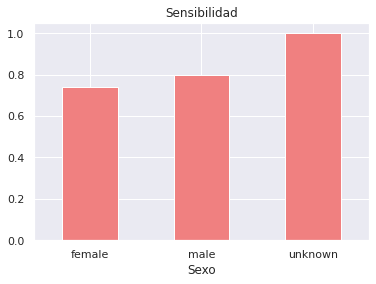

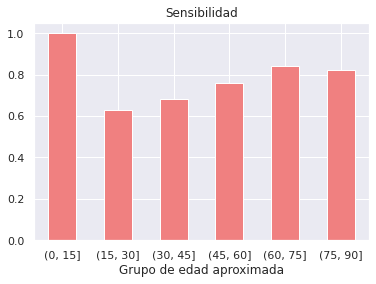

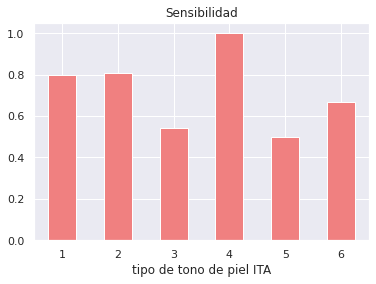

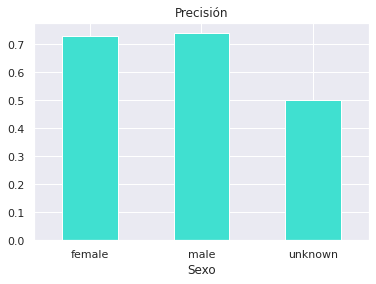

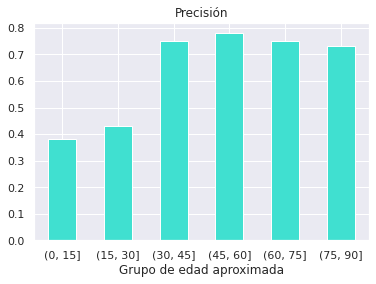

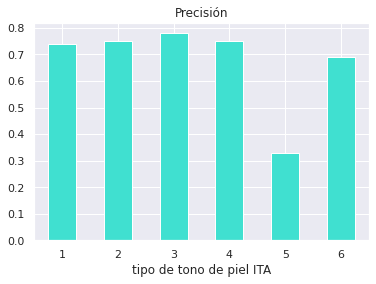

In [60]:
# Representación gráfica
col_bars = {
    "sex": "Sexo",
    "age_group_approx": "Grupo de edad aproximada",
    "tipo_ITA": "tipo de tono de piel ITA"
}

# Sensibilidad
for key, value in col_bars.items():
  ax = data_equity[data_equity['attribute_name'] == key][['attribute_value', 'tpr']]\
                                                    .plot.bar(x="attribute_value", y="tpr",
                                                              legend=None,
                                                              rot=0, color="lightcoral");
  ax.set_title("Sensibilidad")
  ax.set_xlabel(value);
  plt.show();       


# Precisión
for key, value in col_bars.items():
  ax = data_equity[data_equity['attribute_name'] == key][['attribute_value', 'precision']]\
                                                    .plot.bar(x="attribute_value", y="precision",
                                                              legend=None,
                                                              rot=0, color="turquoise");
  ax.set_title("Precisión")
  ax.set_xlabel(value);
  plt.show();  


In [21]:
b = Bias()
# Se toma como referencia hombres entre 30 y 45 años de tono de piel clara
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fairness, 
                                        ref_groups_dict={'sex':'male', 
                                                         'tipo_ITA': '1',
                                                         'age_group_approx':'(30, 45]'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,655,sex,female,0.742958,0.941265,0.055178,0.269896,0.058735,0.257042,0.944822,0.730104,289,1323,0.441221,0.179280,78,73,1250,211,284,1328,1612,3483,0.176179,False,False,1.056116,male,False,1.300790,male,False,1.237316,male,False,0.961465,male,False,0.988923,male,False,0.802778,male,False,0.916322,male,False,0.980736,male,False,1.002507,male,False,0.925925,male,False
1,0,binary 0/1,655,sex,male,0.802395,0.938911,0.044595,0.255556,0.061089,0.197605,0.955405,0.744444,360,1480,0.549618,0.195652,92,66,1414,268,334,1506,1840,3483,0.181522,False,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False
2,0,binary 0/1,655,sex,unknown,1.000000,0.892857,0.000000,0.500000,0.107143,0.000000,1.000000,0.500000,6,25,0.009160,0.193548,3,0,25,3,3,28,31,3483,0.096774,False,False,1.956522,male,False,0.000000,male,False,0.000000,male,False,1.753882,male,False,1.046676,male,False,0.016667,male,False,0.989247,male,False,0.671642,male,False,0.950950,male,False,1.246269,male,False
3,0,binary 0/1,655,tipo_ITA,1,0.800821,0.937266,0.046212,0.255725,0.062734,0.199179,0.953788,0.744275,524,2099,0.800000,0.199771,134,97,2002,390,487,2136,2623,3483,0.185665,False,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False,1.000000,1,False
4,0,binary 0/1,655,tipo_ITA,2,0.807692,0.953020,0.034014,0.250000,0.046980,0.192308,0.965986,0.750000,28,147,0.042748,0.160000,7,5,142,21,26,149,175,3483,0.148571,False,False,0.977612,1,False,0.965504,1,False,0.736026,1,False,0.748873,1,False,1.012790,1,False,0.053435,1,False,0.800916,1,False,1.007692,1,False,1.016809,1,False,1.008580,1,False
5,0,binary 0/1,655,tipo_ITA,3,0.538462,0.977528,0.064516,0.222222,0.022472,0.461538,0.935484,0.777778,9,93,0.013740,0.088235,2,6,87,7,13,89,102,3483,0.127451,False,True,0.868988,1,False,2.317209,1,False,1.396076,1,False,0.358209,1,False,0.980810,1,False,0.017176,1,True,0.441682,1,True,1.045014,1,False,1.042957,1,False,0.672387,1,False
6,0,binary 0/1,655,tipo_ITA,4,1.000000,0.979167,0.000000,0.250000,0.020833,0.000000,1.000000,0.750000,4,47,0.006107,0.078431,1,0,47,3,3,48,51,3483,0.058824,True,True,0.977612,1,False,0.000000,1,False,0.000000,1,False,0.332090,1,False,1.048452,1,False,0.007634,1,True,0.392606,1,True,1.007692,1,False,1.044705,1,False,1.248718,1,False
7,0,binary 0/1,655,tipo_ITA,5,0.500000,0.935484,0.033333,0.666667,0.064516,0.500000,0.966667,0.333333,3,30,0.004580,0.090909,2,1,29,1,2,31,33,3483,0.060606,False,False,2.606965,1,False,2.510309,1,False,0.721306,1,False,1.028406,1,False,1.013503,1,False,0.005725,1,False,0.455066,1,False,0.447863,1,False,0.998099,1,False,0.624359,1,False
8,0,binary 0/1,655,tipo_ITA,6,0.666667,0.933985,0.072816,0.310345,0.066015,0.333333,0.927184,0.689655,87,412,0.132824,0.174349,27,30,382,60,90,409,499,3483,0.180361,False,False,1.213587,1,False,1.673540,1,False,1.575668,1,False,1.052294,1,False,0.972108,1,False,0.166031,1,False,0.872742,1,False,0.926614,1,False,0.996500,1,False,0.832479,1,False
9,0,binary 0/1,655,age_group_approx,"(0, 15

In [25]:
# Visualiza las métricas de equidad
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].round(2)

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,sex,female,1.06,1.30,1.24,0.96,0.99,0.80,0.92,0.98,...,False,False,False,False,False,False,False,False,False,False
1,sex,male,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,sex,unknown,1.96,0.00,0.00,1.75,1.05,0.02,0.99,0.67,...,False,False,False,False,False,False,False,False,False,False
3,tipo_ITA,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
4,tipo_ITA,2,0.98,0.97,0.74,0.75,1.01,0.05,0.80,1.01,...,False,False,False,False,False,False,False,False,False,False
5,tipo_ITA,3,0.87,2.32,1.40,0.36,0.98,0.02,0.44,1.05,...,False,False,False,False,False,True,True,False,False,False
6,tipo_ITA,4,0.98,0.00,0.00,0.33,1.05,0.01,0.39,1.01,...,False,False,False,False,False,True,True,False,False,False
7,tipo_ITA,5,2.61,2.51,0.72,1.03,1.01,0.01,0.46,0.45,...,False,False,False,False,False,False,False,False,False,False
8,tipo_ITA,6,1.21,1.67,1.58,1.05,0.97,0.17,0.87,0.93,...,False,False,False,False,False,False,False,False,False,False
9,age_group_approx,"(0, 15]",2.50,0.00,0.00,2.06,1.05,0.08,0.91,0.50,...,True,False,False,True,False,False,False,True,True,False


In [23]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25